In [1]:
# import packages
import numpy as np
import math as math
import pandas as pd
from astropy import units as u
import astropy.constants as const

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
def get_params(filename):
    """Get orbit params from csv header"""
    header = np.array([])
    file = open(filename, 'r')
    for line in file:
        if line.startswith("#"):
            line.split(",")
            header = np.append(header,line.split(","))
    P = float(header[5].split(" ")[-2])
    dur = float(header[6].split(" ")[-2])
    return P, dur

In [14]:
def calculate_residual(sim, obs):
    """
    Calculate residual between simulated and observed data.
    Interpolates simulated data to match observed data timestamps.
    
    Inputs
        sim, obs: DataFrames with time, rv, theta
    Returns
        t_obs, residual: array of times for observations, and residuals
        
    NB: t_obs is shortened by 10 indices at the end to avoid going out of
      range of the interpolated observed data
      
    """
    
    t_sim = np.array(sim['# time [d]'])
    end = len(obs)//50
    t_obs = np.array(obs['# time [d]'])[end:-end] # d -> hrs
    
    simrv = sim['radial velocity [m/s]'].to_numpy()
    obsrv = obs['radial velocity [m/s]'].to_numpy()[end:-end]

    # interpolate the simulated data onto the synthetic observed time steps
    f_interp = interp1d(t_sim, simrv)
    simobsrv = f_interp(t_obs)
    # calculate the (sim - obs) residual
    residual = simobsrv - obsrv
    
    return t_obs*24, residual


In [15]:
koi = 961.01


file_asim = "rv_lcs/KOI_961.01_sim_rmrv_lc_b_0.0_phi_0.0278pi.csv"
P, dur = get_params(file_asim)
P *= 24   # convert to hours

# case A is the predicted
case_a_sim = pd.read_csv('rv_lcs/KOI_961.01_sim_rmrv_lc_b_0.0_phi_0.0pi.csv',
                    header=4)
case_a_obs = pd.read_csv('rv_lcs/KOI_961.01_synthobs_rmrv_lc_b_0.0_phi_0.0pi.csv',
                    header=4)

# case B is the random
case_b_sim = pd.read_csv('rv_lcs/KOI_961.01_sim_rmrv_lc_b_0.0_phi_0.0278pi.csv',
                    header=4)
case_b_obs = pd.read_csv('rv_lcs/KOI_961.01_synthobs_rmrv_lc_b_0.0_phi_0.0278pi.csv',
                    header=4)

In [20]:
koi = 254.01

# case A is the predicted
case_a_sim = pd.read_csv('rv_lcs/KOI_254.01_sim_rmrv_lc_b_0.0_phi_0.0pi.csv',
                    header=4)
case_a_obs = pd.read_csv('rv_lcs/KOI_254.01_synthobs_rmrv_lc_b_0.0_phi_0.0pi.csv',
                    header=4)

# case B is the random
case_b_sim = pd.read_csv('rv_lcs/KOI_254.01_sim_rmrv_lc_b_0.0_phi_0.111pi.csv',
                    header=4)
case_b_obs = pd.read_csv('rv_lcs/KOI_254.01_synthobs_rmrv_lc_b_0.0_phi_0.111pi.csv',
                    header=4)


file_asim = "rv_lcs/KOI_254.01_sim_rmrv_lc_b_0.0_phi_0.0pi.csv"
P, dur = get_params(file_asim)
P *= 24   # convert to hours


In [21]:
t_a, res_a = calculate_residual(case_a_sim, case_a_obs)
t_b, res_b = calculate_residual(case_b_sim, case_b_obs)

In [22]:
## set error parameters (from MAROON-X, Jenn Burt)
sigma_phot = 1.7   # RV photon uncertainty [m/s]
sigma_floor = 0.5  # RV instrument floor [m/s]
sigma_jit = 0.5    # Stellar jitter term [m/s]
sigma_all = np.sqrt(sigma_phot**2 + sigma_floor**2 + sigma_jit**2) # Add all unc. terms in quadrature


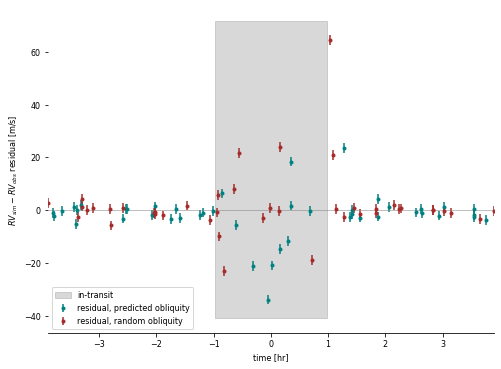

In [23]:
### Plot residuals ###

# figure setup
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
fs = 14 # font size
plt.rc('font', size=fs)


ax.errorbar(t_a - P, res_a, yerr=sigma_all,
            c='teal', fmt='.',label=f"residual, predicted obliquity"
           )
ax.errorbar(t_b - P, res_b, yerr=sigma_all,
            c='brown', fmt='.',label=f"residual, random obliquity"
           )


# formatting
ax.set_xlabel(r"time [hr]")
ax.set_ylabel(r"$RV_{sim} - RV_{obs}$ residual [m/s]")


window = np.array([-1,1])*2*dur
ax.set_xlim(window[0], window[1])

# # additional visual markers
# ax.vlines(0.5*(dur)*np.array([-1,1]),ax.get_ylim()[0],ax.get_ylim()[1],
#           color='grey', alpha=0.4 , label=f"dur = {dur:.3}")

corner = (-dur*0.5, ax.get_ylim()[0])
width = dur  # hrs
height = np.diff(ax.get_ylim())[0]
ax.add_patch(Rectangle(corner, width, height,
                      color='grey', alpha=0.3, zorder=1,
                      label="in-transit"))
ax.hlines(0,window[0],window[1],lw=1,colors='grey',alpha=0.5)

for spine in ax.spines: ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_visible(True)

# plt.text(ax.get_xlim()[0]*0.5, ax.get_ylim()[1]*0.75, f"stellar obliquity = {phi_star * (180/np.pi):.3} deg")

#ax.set_facecolor("lightgrey")
#plt.grid(c='white')
plt.rc('font', size=8)
plt.legend(loc='lower left')

filename=f"plots/KOI_{koi}_residuals.svg"
plt.savefig(filename, bbox_inches='tight',transparent=True)

In [ ]:
dur